In [1]:
#!pip install --upgrade qiskit

In [2]:
%matplotlib inline
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
#provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Qiskit Summer School Final Project: VQE

## Some defintions

In [3]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    #ee = ExactEigensolver(qubitOp)
    ee = NumPyEigensolver(qubitOp)
    result = ee.run()
    ref = result['eigenvalues']
    #print('Reference value: {}'.format(ref))
    return ref

In [4]:
backend = BasicAer.get_backend('statevector_simulator')

In [5]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

In [6]:
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    #freeze_list = [0,6] 
    #remove_list = [3,8]
    print("remove_list=",remove_list)
    print("freeze_list=",freeze_list)

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp #that is: if map_type == 'parity' do two_qibit_reduction, else do nothing 
    qubitOp.chop(10**-10)
    total_en_shift = energy_shift + nuclear_repulsion_energy

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift

## Setting molecule

In [7]:
inter_dist = 1.6
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(map_type,inter_dist)

HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]


In [8]:
ref = exact_solver(qubitOp)

print("ref. energy=",np.round(np.real(ref[0]),4))
print("total_en_shift",np.round(total_en_shift,4))
exact_energy = np.real(ref[0] + total_en_shift)
print("exact energy=",np.round(exact_energy,4))

ref. energy= -1.0771
total_en_shift -6.804
exact energy= -7.8811


In [9]:
backend = BasicAer.get_backend("statevector_simulator")

for maxter in [5,10]:
    optimizer = SLSQP(maxiter=maxter)

    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
    print("Max iter.:",maxter,"VQE Result:", vqe_result, "Exact Energy:", exact_energy)

Max iter.: 5 VQE Result: -7.8810366266663365 Exact Energy: -7.881072044030918
Max iter.: 10 VQE Result: -7.881072027638027 Exact Energy: -7.881072044030918


In [10]:
optimizer = SLSQP(maxiter=5)

initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping=map_type
) 
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping=map_type
)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result:", vqe_result, "Exact Energy:", exact_energy)

VQE Result: -7.8810366266663365 Exact Energy: -7.881072044030918


In [11]:
counts_SLSQP = counts
energies_SLSQP = values + total_en_shift
deviation_SLSQP = deviation

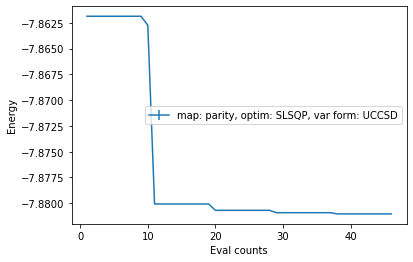

In [12]:
plt.errorbar(counts_SLSQP,energies_SLSQP,yerr=deviation_SLSQP,label="map: parity, optim: SLSQP, var form: UCCSD")
plt.xlabel('Eval counts')
plt.ylabel('Energy')
plt.legend()